# Indian Air Quality Monitoring and Forecasting

This project analyzes historical air quality data of India (1990–2015) and builds a complete
air quality monitoring system using data analysis, machine learning, and time-series forecasting.

Objectives:
- Calculate AQI using standard pollutant-based formulas
- Predict AQI using machine learning models
- Forecast future AQI trends using ARIMA
- Classify air quality levels
- Provide health recommendations based on AQI

## Dataset Description

The dataset contains historical daily air pollution data collected from various monitoring
stations across India. The data is published by CPCB and MoEF under NDSAP.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


from statsmodels.tsa.arima.model import ARIMA
import pickle

In [16]:
df = pd.read_csv("data.csv", encoding="latin1", low_memory=False)
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [17]:
df.shape

(435742, 13)

In [18]:
df.columns

Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

Data Preprocessing

In [20]:
# Convert Date Column
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date')

In [21]:
# Handle Missing Values
pollutants = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']
df[pollutants] = df[pollutants].fillna(df[pollutants].mean())

In [22]:
df[pollutants].isnull().sum()

,0
so2,0
no2,0
rspm,0
spm,0
pm2_5,0


Standards-Based AQI Calculation

In [24]:
# AQI Formula
def calculate_aqi(C, Blo, Bhi, Ilo, Ihi):
  return ((Ihi - Ilo) / (Bhi - Blo)) * (C - Blo) + Ilo

In [25]:
# PM2.5 AQI Breakpoints (CPCB Style)
def pm25_aqi(pm):
  if pm <= 30:
    return calculate_aqi(pm, 0, 30, 0, 50)
  elif pm <= 60:
    return calculate_aqi(pm, 31, 60, 51, 100)
  elif pm <= 90:
    return calculate_aqi(pm, 61, 90, 101, 200)
  elif pm <= 120:
    return calculate_aqi(pm, 91, 120, 201, 300)
  else:
    return calculate_aqi(pm, 121, 250, 301, 500)

In [27]:
# Apply AQI Calculation
df['AQI'] = df['pm2_5'].apply(pm25_aqi)

# Verify AQI
df['AQI'].isnull().sum()

np.int64(0)

Exploratory Data Analysis (EDA)

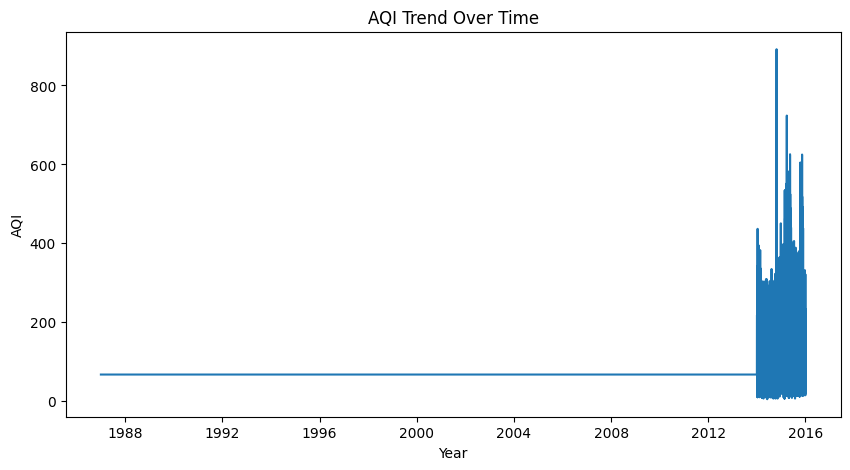

In [28]:
# AQI Trend Over Time
plt.figure(figsize=(10,5))
plt.plot(df['date'], df['AQI'])
plt.xlabel("Year")
plt.ylabel("AQI")
plt.title("AQI Trend Over Time")
plt.show()

Machine Learning AQI Prediction

In [31]:
# Feature Selection
X = df[['so2', 'no2', 'rspm', 'spm', 'pm2_5']]
y = df['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
# Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.00098627125596346

Time-Series Forecasting (ARIMA)

In [35]:
# Prepare AQI Time Series
aqi_ts = df.groupby('date')['AQI'].mean()

# Train ARIMA Model
arima_model = ARIMA(aqi_ts, order=(1,1,1))
arima_fit = arima_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [36]:
# Forecast Future AQI
forecast = arima_fit.forecast(steps=365)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


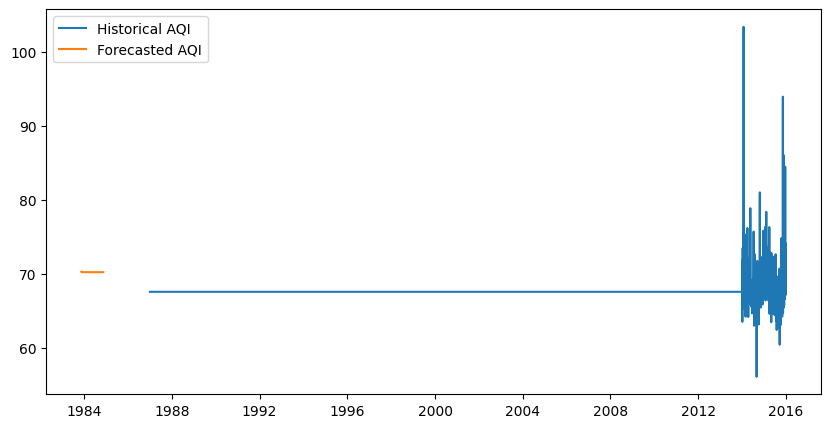

In [37]:
plt.figure(figsize=(10,5))
plt.plot(aqi_ts, label="Historical AQI")
plt.plot(forecast, label="Forecasted AQI")
plt.legend()
plt.show()

AQI Classification & Health Recommendation System

In [38]:
# AQI Category
def aqi_category(aqi):
  if aqi <= 50:
    return "Good"
  elif aqi <= 100:
    return "Moderate"
  elif aqi <= 200:
    return "Poor"
  elif aqi <= 300:
    return "Unhealthy"
  else:
    return "Hazardous"

def health_advice(category):
  advice = {
"Good": "Air quality is satisfactory. Enjoy outdoor activities.",
"Moderate": "Sensitive individuals should limit outdoor exertion.",
"Poor": "Avoid prolonged outdoor activities.",
"Unhealthy": "Wear masks and avoid going outside.",
"Hazardous": "Stay indoors and seek medical assistance."
}
  return advice[category]

In [40]:
# Apply Classification
df['AQI_Category'] = df['AQI'].apply(aqi_category)
df['Health_Advice'] = df['AQI_Category'].apply(health_advice)
df[['AQI', 'AQI_Category', 'Health_Advice']].head()

,AQI,AQI_Category,Health_Advice
413276,67.544203,Moderate,Sensitive individuals should limit outdoor exe...
413279,67.544203,Moderate,Sensitive individuals should limit outdoor exe...
413282,67.544203,Moderate,Sensitive individuals should limit outdoor exe...
368217,67.544203,Moderate,Sensitive individuals should limit outdoor exe...
80622,67.544203,Moderate,Sensitive individuals should limit outdoor exe...


In [42]:
pickle.dump(model, open("model.pkl", "wb"))